<a href="https://colab.research.google.com/github/dohyeon-kim012/MachineLearning-DeepLearning/blob/main/DeepLearning/%EC%8B%A4%EC%8A%B5_%ED%85%8D%EC%8A%A4%ED%8A%B8%20%EB%B6%84%EB%A5%98%EB%A5%BC%20%EC%9C%84%ED%95%9C%20RNN%20%EB%AA%A8%EB%8D%B8%20%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN 모델을 통한 다중 분류

- 크롤링한 `daum 뉴스` 데이터를 이용
- **목표** : 기사 제목과 내용을 바탕으로 기사의 카테고리를 분류할 수 있는 모델을 만드는 것

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install konlpy

In [ ]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import urllib.request

import matplotlib.pyplot as plt
import seaborn as sns
import re

from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 텍스트 데이터 전처리

크롤링을 통해 여러 개의 데이터프레임이 만들어졌기 때문에,  
데이터프레임을 불러와 병합(`concat`)한다

In [ ]:
df_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/csv/df_1.csv')
df_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/csv/df_2.csv')
df_3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/csv/df_3.csv')
df_4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/csv/df_4.csv')
df_5 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/csv/df_5.csv')
df_6 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/csv/df_6.csv')
df_7 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/csv/df_7.csv')
df_8 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/csv/df_8.csv')
df_9 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/csv/20210501_1.csv')
df_10 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/csv/20210501_2.csv')
df_11 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/csv/df_20210501_2.csv')
df_12 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/csv/df_20210501_3.csv')
df_13 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/csv/df_20210701.csv')
df_datas = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10, df_11, df_12, df_13], ignore_index=True)
df_datas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37068 entries, 0 to 37067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  37068 non-null  object
 1   news_url  37068 non-null  object
 2   title     37068 non-null  object
 3   content   37035 non-null  object
dtypes: object(4)
memory usage: 1.1+ MB


In [ ]:
df_datas

,category,news_url,title,content
0,society,https://v.daum.net/v/20210714184916396,"한국폴리텍Ⅲ대학, 춘천기계공고와 산학협력 협약",[서동일 기자(=춘천)(tami80@pressian.com)]정부산하 국책기술대학인...
1,society,https://v.daum.net/v/20210714184906394,비수도권 신규 확진 4백명 육박..거리두기 강화에도 확산세 안 꺾여,[앵커] \n수도권 밖에서도 4백 명에 육박하는 확진자가 나오면서 확산세가 좀처럼 ...
2,society,https://v.daum.net/v/20210714184807381,오후 6시 전국 1263명 확진..전날보다 25명↓,13일 오전 서울 성북구 돈암동 성북천 변에 마련된 임시선별검사소에 코로나19 검사...
3,society,https://v.daum.net/v/20210714184804378,"부산 ""e스포츠 산업이 新성장동력""","이필성 샌드박스네크워크 및 샌드박스게이밍 대표(왼쪽부터)와 박형준 부산시장, 이인숙..."
4,society,https://v.daum.net/v/20210714184758374,[속보] 오후 6시 또 1200명 넘게 확진..내일도 1600명 안팎 나올 듯,폭염특보가 내려진 14일 서울광장 코로나19 임시선별검사소를 찾은 시민들이 검사를 ...
...,...,...,...,...
37063,digital,https://v.daum.net/v/20210701101910837,"KT, 빅데이터 기반 해수욕장 혼잡도 공개",KT가 해양수산부와 7월부터 두 달간 전국 264개 해수욕장에 대해 빅데이터 기반 ...
37064,digital,https://v.daum.net/v/20210701101851830,"신수정 KT 부사장 ""디지털 전환은 기업생존 결정 요소""",(지디넷코리아=박수형 기자)신수정 KT 엔터프라이즈부문장이 온라인으로 진행된 GTI...
37065,digital,https://v.daum.net/v/20210701102159178,'네이버 주문' 처음 도입한 사업자에게 6개월간 수수료 지원,[네이버 제공. 재판매 및 DB 금지]\n \n\n(서울=연합뉴스...
37066,digital,https://v.daum.net/v/20210701101811795,430억 투입 AI기반 중량화물이동체 물류플랫폼 실증 사업단 출범,(지디넷코리아=방은주 기자)과학기술정보통신부(과기정통부)는 울산광역시(시장 송철호)...


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

### 중복 데이터 확인

In [ ]:
# 중복값 확인
df_datas['title'].duplicated().value_counts()

True     27414
False     9654
Name: title, dtype: int64

In [ ]:
# 중복값이 실제로 존재하는지 정렬을 통해 재확인
df_datas.sort_values(by=['title'], ascending=True)

,category,news_url,title,content
30560,society,https://v.daum.net/v/20210510220447276,"""'녹지 불법 점용' 규제자유특구 태양광시설 철거""",[KBS 광주]전남 에너지신산업 규제자유특구의 인도형 태양광 시설이 나주 혁신산단 ...
32233,culture,https://v.daum.net/v/20210510180744717,"""'레미제라블' 내한 콘서트, 저작권자 승인 받지 않은 공연""",[서울=뉴시스] '레미제라블' 관련 공지문. 2021.05.10. (사진 = 홈페이...
32198,culture,https://v.daum.net/v/20210510190921853,"""'레미제라블' 내한 콘서트, 저작권자 승인 받지 않은 공연""..논란",[사진 레미제라블코리아는 공식 홈페이지 캡처]\n \n\n 이달 ...
32276,culture,https://v.daum.net/v/20210510173818668,"""'레미제라블' 내한 콘서트는 저작권 승인 안 받은 공연""",[이데일리 장병호 기자] 오는 15일부터 부산과 서울에서 공연 예정인 ‘프랑스 오리...
28959,culture,https://v.daum.net/v/20210501121352063,"""'모든 이의 모든 것' 위한 삶""..故정진석 추기경 장례미사 봉헌 [종합]",(사진=cpbc 유튜브 생중계 화면)\n \n\n\n ...
...,...,...,...,...
34118,politics,https://v.daum.net/v/20210701195026928,흙수저 출신 대권후보 이재명.. 친문협공·욕설녹취 최대난관,국기에 대한 경례하는 이재명 (서울=연합뉴스) 하사헌 기자 = 더불어민주당 대선 경...
34510,economic,https://v.daum.net/v/20210701183054058,힙합 비트 공유 플랫폼 '제이원비츠' 홈페이지 새단장,리뉴얼된 제이원비츠 홈페이지/사진=일학교\n \n\n힙합 비트 공...
34239,politics,https://v.daum.net/v/20210701185017496,"女중사 남편측, '성추행 은폐 의혹' 공군 군사경찰단장 고소",[그래픽] '여중사 성추행 사망 사건' 공군경찰 은폐 문건 (서울=연합뉴스) 김토일...
34018,society,https://v.daum.net/v/20210701202639643,"女중사 남편측, '성추행 은폐 의혹' 공군 군사경찰단장 고소",경기도 성남시 국군수도병원에 마련된 고(故) 이모 중사의 분향소를 찾은 조문객들이 ...


In [ ]:
df_datas.drop_duplicates(subset=['title'], keep='first', ignore_index=True, inplace=True)
df_datas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9654 entries, 0 to 9653
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  9654 non-null   object
 1   news_url  9654 non-null   object
 2   title     9654 non-null   object
 3   content   9639 non-null   object
dtypes: object(4)
memory usage: 301.8+ KB


### 텍스트 데이터 정제 - 정규식

In [ ]:
# title(기사 제목) column 정제
df_datas['title'] = df_datas['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
df_datas.head()

,category,news_url,title,content
0,society,https://v.daum.net/v/20210714184916396,한국폴리텍대학춘천기계공고와 산학협력 협약,[서동일 기자(=춘천)(tami80@pressian.com)]정부산하 국책기술대학인...
1,society,https://v.daum.net/v/20210714184906394,비수도권 신규 확진 백명 육박거리두기 강화에도 확산세 안 꺾여,[앵커] \n수도권 밖에서도 4백 명에 육박하는 확진자가 나오면서 확산세가 좀처럼 ...
2,society,https://v.daum.net/v/20210714184807381,오후 시 전국 명 확진전날보다 명,13일 오전 서울 성북구 돈암동 성북천 변에 마련된 임시선별검사소에 코로나19 검사...
3,society,https://v.daum.net/v/20210714184804378,부산 스포츠 산업이 성장동력,"이필성 샌드박스네크워크 및 샌드박스게이밍 대표(왼쪽부터)와 박형준 부산시장, 이인숙..."
4,society,https://v.daum.net/v/20210714184758374,속보 오후 시 또 명 넘게 확진내일도 명 안팎 나올 듯,폭염특보가 내려진 14일 서울광장 코로나19 임시선별검사소를 찾은 시민들이 검사를 ...


In [ ]:
# content column 정제
df_datas['content'] = df_datas['content'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
df_datas.head()

,category,news_url,title,content
0,society,https://v.daum.net/v/20210714184916396,한국폴리텍대학춘천기계공고와 산학협력 협약,서동일 기자춘천정부산하 국책기술대학인 한국폴리텍대학학장 이덕수 춘천캠퍼스가 일 춘천...
1,society,https://v.daum.net/v/20210714184906394,비수도권 신규 확진 백명 육박거리두기 강화에도 확산세 안 꺾여,앵커 수도권 밖에서도 백 명에 육박하는 확진자가 나오면서 확산세가 좀처럼 꺾이지 않...
2,society,https://v.daum.net/v/20210714184807381,오후 시 전국 명 확진전날보다 명,일 오전 서울 성북구 돈암동 성북천 변에 마련된 임시선별검사소에 코로나 검사를 받으...
3,society,https://v.daum.net/v/20210714184804378,부산 스포츠 산업이 성장동력,이필성 샌드박스네크워크 및 샌드박스게이밍 대표왼쪽부터와 박형준 부산시장 이인숙 부산...
4,society,https://v.daum.net/v/20210714184758374,속보 오후 시 또 명 넘게 확진내일도 명 안팎 나올 듯,폭염특보가 내려진 일 서울광장 코로나 임시선별검사소를 찾은 시민들이 검사를 받기 위...


In [ ]:
df_datas['content'].replace("", np.nan, inplace=True)
df_datas = df_datas.dropna(how='any')

df_datas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9635 entries, 0 to 9653
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  9635 non-null   object
 1   news_url  9635 non-null   object
 2   title     9635 non-null   object
 3   content   9635 non-null   object
dtypes: object(4)
memory usage: 376.4+ KB


### label 값 숫자로 변경

`label`이 될 `category` column의 값이 영문으로 되어 있기 때문에 숫자로 바꿔야 함  

`society` : `0`  
`politics` : `1`  
`economic` : `2`  
`foreign` : `3`  
`culture` : `4`  
`digital` : `5`

In [ ]:
df_datas['category'].unique()

array(['society', 'politics', 'economic', 'foreign', 'culture', 'digital'],
      dtype=object)

In [ ]:
# 값 변경하기
df_datas.loc[(df_datas['category'] == 'society'), 'category'] = 0
df_datas.loc[(df_datas['category'] == 'politics'), 'category'] = 1
df_datas.loc[(df_datas['category'] == 'economic'), 'category'] = 2
df_datas.loc[(df_datas['category'] == 'foreign'), 'category'] = 3
df_datas.loc[(df_datas['category'] == 'culture'), 'category'] = 4
df_datas.loc[(df_datas['category'] == 'digital'), 'category'] = 5
df_datas

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid d

,category,news_url,title,content
0,0,https://v.daum.net/v/20210714184916396,한국폴리텍대학춘천기계공고와 산학협력 협약,서동일 기자춘천정부산하 국책기술대학인 한국폴리텍대학학장 이덕수 춘천캠퍼스가 일 춘천...
1,0,https://v.daum.net/v/20210714184906394,비수도권 신규 확진 백명 육박거리두기 강화에도 확산세 안 꺾여,앵커 수도권 밖에서도 백 명에 육박하는 확진자가 나오면서 확산세가 좀처럼 꺾이지 않...
2,0,https://v.daum.net/v/20210714184807381,오후 시 전국 명 확진전날보다 명,일 오전 서울 성북구 돈암동 성북천 변에 마련된 임시선별검사소에 코로나 검사를 받으...
3,0,https://v.daum.net/v/20210714184804378,부산 스포츠 산업이 성장동력,이필성 샌드박스네크워크 및 샌드박스게이밍 대표왼쪽부터와 박형준 부산시장 이인숙 부산...
4,0,https://v.daum.net/v/20210714184758374,속보 오후 시 또 명 넘게 확진내일도 명 안팎 나올 듯,폭염특보가 내려진 일 서울광장 코로나 임시선별검사소를 찾은 시민들이 검사를 받기 위...
...,...,...,...,...
9649,5,https://v.daum.net/v/20210701101907835,갤럭시 울트라 최고의 스마트폰 선정,삼성전자 갤럭시 울트라 삼성전자 갤럭시 울트라 가 최고의 스...
9650,5,https://v.daum.net/v/20210701101910837,빅데이터 기반 해수욕장 혼잡도 공개,가 해양수산부와 월부터 두 달간 전국 개 해수욕장에 대해 빅데이터 기반 해수욕장 혼...
9651,5,https://v.daum.net/v/20210701101851830,신수정 부사장 디지털 전환은 기업생존 결정 요소,지디넷코리아박수형 기자신수정 엔터프라이즈부문장이 온라인으로 진행된 서밋 에서 ...
9652,5,https://v.daum.net/v/20210701101811795,억 투입 기반 중량화물이동체 물류플랫폼 실증 사업단 출범,지디넷코리아방은주 기자과학기술정보통신부과기정통부는 울산광역시시장 송철호 정보통신산업...


#### label 비율 확인

레이블 간의 비율을 시각화하여 확인하기

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


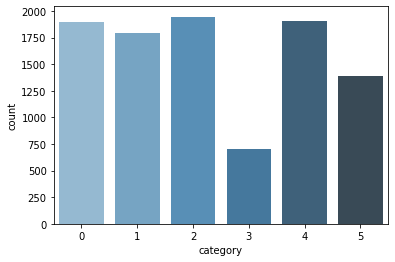

In [ ]:
sns.countplot(df_datas['category'], palette="Blues_d")
plt.show()

`label` 확인 결과 '3'의 값이 현저히 적다는 것을 확인할 수 있다  

### 불용어 선정

In [ ]:
stopwords = ['의','가','이','은','등','것','돼다','되다','있다','하고','들','받다','면서','고','는','좀','부터','까지','잘','걍','과','도','를','을','에서','로','이다','으로','자','에','와','한','하다','일','수','적','전','인','명','기자','년','다','않다','월','원','보다','만','말','위','지난','통해']

### 문장 단위로 데이터 split

In [ ]:
!pip install kss

     |████████████████████████████████| 71kB 3.3MB/s 


In [ ]:
import kss
data_split_sentence = [kss.split_sentences(data) for data in df_datas['content']]

문장별로 split 한 후, 데이터를 okt에 넣기 전 미리 nan 값을 지워줘야 오류가 발생하지 않는다  
따라서 내용의 길이가 '1' 미만인, 즉 '0'인 배열을 찾아 delete 한다

In [ ]:
nan_list = [index for index, sentence in enumerate(data_split_sentence) if len(sentence) < 1]
len(nan_list)

399

In [ ]:
split_final = np.delete(data_split_sentence, nan_list, axis=0)
split_final.shape

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(9236,)

### 토큰화 및 불용어 처리

In [ ]:
from tqdm.notebook import tqdm
from konlpy.tag import Okt

okt = Okt()

X_train = []

for idx in tqdm(range(len(split_final))):

    for sentence in split_final[idx]:
        temp_X = []
        temp_X = okt.morphs(sentence, stem=True)

        temp_X = [ word for word in temp_X if not word in stopwords ]
        X_train.append(temp_X)

In [ ]:
X_train[:2]

[['서',
  '동일',
  '춘천',
  '정',
  '부산하다',
  '국책',
  '기술',
  '대학',
  '한국',
  '폴리텍',
  '대학',
  '학장',
  '이덕수',
  '춘천',
  '캠퍼스',
  '춘천',
  '기계',
  '공업고등학교',
  '교장',
  '정명',
  '진',
  '산학',
  '협력',
  '협약'],
 ['춘천',
  '기계',
  '공고',
  '공립',
  '공업고등학교',
  '산학',
  '일체',
  '형',
  '도제',
  '학교',
  '한국',
  '폴리텍',
  '대학',
  '산학',
  '일체',
  '형',
  '도제',
  '학교',
  '란',
  '기업',
  '학생',
  '근로자',
  '직접',
  '채용',
  '형태',
  '고교',
  '단계',
  '학습',
  '병행',
  '제',
  '운영',
  '학교',
  '도제',
  '학교',
  '재학',
  '중인',
  '학생',
  '학교',
  '기업체',
  '오가다',
  '현장',
  '중심',
  '실무',
  '교육',
  '이론',
  '교육',
  '동시',
  '한국',
  '폴리텍',
  '대학',
  '춘천',
  '캠퍼스',
  '이러하다',
  '도제',
  '학교',
  '졸업',
  '예정자',
  '기업체',
  '재직',
  '중인',
  '자르다',
  '대상',
  '숙련',
  '학습',
  '병행',
  '과정',
  '이하',
  '과정',
  '운영']]

### 토크나이저 만들기

희귀 단어의 임계점을 정하기 위해 임시 토크나이저 실행

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

{'없다': 1, '서울': 2, '그': 3, '밝히다': 4, '코로나': 5, '국민': 6, '따르다': 7, '대표': 8, '에는': 9, '사업': 10, '대한': 11, '아니다': 12, '의원': 13, '위해': 14, '에게': 15, '제': 16, '시': 17, '더': 18, '지': 19, '이라고': 20, '및': 21, '대해': 22, '같다': 23, '중': 24, '내': 25, '한국': 26, '성': 27, '정부': 28, '날': 29, '오다': 30, '백신': 31, '장': 32, '제공': 33, '대통령': 34, '접종': 35, '개': 36, '관련': 37, '나오다': 38, '이번': 39, '때': 40, '진행': 41, '그렇다': 42, '지역': 43, '기업': 44, '서비스': 45, '사진': 46, '많다': 47, '이상': 48, '시간': 49, '함께': 50, '나': 51, '때문': 52, '분': 53, '씨': 54, '서': 55, '시장': 56, '가다': 57, '크다': 58, '뉴스': 59, '사람': 60, '또': 61, '우리': 62, '생각': 63, '지원': 64, '상황': 65, '기': 66, '못': 67, '세': 68, '대': 69, '기술': 70, '이후': 71, '에서는': 72, '계획': 73, '문제': 74, '당': 75, '안': 76, '주': 77, '경우': 78, '게': 79, '미국': 80, '힘': 81, '조': 82, '차': 83, '지난해': 84, '달': 85, '에도': 86, '시작': 87, '민주당': 88, '늘다': 89, '들다': 90, '보이다': 91, '최근': 92, '점': 93, '투자': 94, '국내': 95, '개발': 96, '정책': 97, '대다': 98, '사': 99, '경제': 100, '연합뉴스': 101, '연': 102, '확'

### 빈도수가 적은 단어 제외

In [ ]:
# 임계점 설정
threshold = 8

total_cnt = len(tokenizer.word_index)
rare_cnt = 0

total_freq = 0 
rare_freq = 0 

for key, value in tokenizer.word_counts.items():
    total_freq += value

    if value < threshold:
        rare_cnt += 1
        rare_freq += value

print("전체 단어 집합 총 개수 : {}".format(total_cnt))
print("희귀 단어 총 개수 : {}".format(rare_cnt))
print("희귀 단어 비율 : {:.2f}%".format((rare_cnt / total_cnt) * 100))
print("희귀 단어 등장 빈도 비율 : {:.2f}%".format((rare_freq / total_freq) * 100))

전체 단어 집합 총 개수 : 47939
희귀 단어 총 개수 : 30467
희귀 단어 비율 : 63.55%
희귀 단어 등장 빈도 비율 : 3.16%


희귀 단어의 임계점을 8 로 했을 때, 등장 빈도 비율에 비해 단어의 비율이 많다고 보여진다  
따라서 임계점은 8 로 잡았다

### 토크나이저 다시 만들기  
빈도수, padding, oov 고려할 것

In [ ]:
#토크나이저를 만들기 전, 전체단어에서 희귀단어를 뺀 'vocab_size' 변수 생성
vocab_size = total_cnt - rare_cnt + 2 # 2 : <oov> + <pad>
print(vocab_size)

17474


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token='<oov>')
tokenizer.fit_on_texts(X_train)

### 정수 인코딩

In [ ]:
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_train_encoded[0]

[56,
 3397,
 2123,
 251,
 1,
 9163,
 71,
 644,
 27,
 13519,
 644,
 13520,
 1,
 2123,
 2348,
 2123,
 2334,
 1,
 7507,
 11642,
 799,
 3815,
 358,
 784]

### 비어있는 배열 제거

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train_encoded) if len(sentence) < 1]
drop_train

[7970, 15040, 33740, 36125, 41066, 41126, 41243, 63060, 68005, 73769]

In [ ]:
X_train[54]

['서울',
 '서초구',
 '고속',
 '터미널',
 '앞',
 '임',
 '시선',
 '별',
 '검사',
 '소',
 '노랗다',
 '우산',
 '쓸다',
 '시민',
 '검사',
 '대기']

In [ ]:
X_train_encoded_final = np.delete(X_train_encoded, drop_train, axis=0)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
X_train_encoded_final

array([list([56, 3397, 2123, 251, 1, 9163, 71, 644, 27, 13519, 644, 13520, 1, 2123, 2348, 2123, 2334, 1, 7507, 11642, 799, 3815, 358, 784]),
       list([2123, 2334, 3204, 10929, 1, 3815, 5092, 157, 13521, 782, 27, 13519, 644, 3815, 5092, 157, 13521, 782, 2218, 45, 758, 1264, 367, 1034, 974, 5318, 454, 1896, 3920, 17, 132, 782, 13521, 782, 8043, 733, 758, 782, 8931, 3683, 294, 329, 2416, 302, 3816, 302, 792, 27, 13519, 644, 2123, 2348, 1305, 13521, 782, 2297, 5628, 8931, 4128, 733, 3040, 148, 8044, 1896, 3920, 184, 765, 184, 132]),
       list([2123, 2348, 3021, 184, 1794, 2018, 3598, 3022]), ...,
       list([3, 2353, 1650, 56, 1935, 51, 402, 380, 6702, 370, 421, 784, 1963, 402, 628, 993, 2878, 1269, 46, 1, 617, 65]),
       list([113, 2161, 2247, 1736, 380, 4841, 15, 12297, 1736, 628, 148, 7688, 380, 2569, 46, 370, 11, 200, 355, 1626, 51, 1736, 1572, 664, 947, 50, 395, 1005, 876, 1910, 46, 11, 42]),
       list([8395, 7601, 7045, 9, 175, 543, 390, 7045, 230, 4119, 1912, 2642, 315, 23

In [ ]:
X_train_encoded_final.shape

(79722,)

### 'y_train' 생성

In [ ]:
y_train = np.array(df_datas['category'])
y_split_label = []

for i in range(len(split_final)):
  for j in range(len(split_final[i])):
    y_split_label.append(y_train[i])

y_split_label
y_train = np.array(y_split_label)
y_train.shape

(79732,)

In [ ]:
y_train

array([0, 0, 0, ..., 4, 4, 4])

### 패딩 설정하기

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


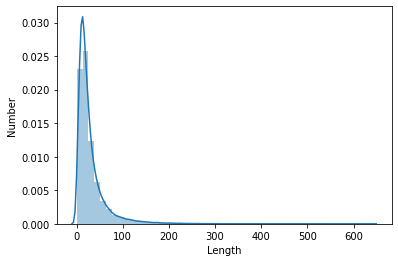

In [ ]:
# 패딩 설정에서의 적절한 길이를 확인하기 위해 최대 길이와 평균 길이를 시각화로 비교
sns.distplot([len(s) for s in X_train])
plt.xlabel("Length")
plt.ylabel("Number")
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if len(s) <= max_len:
            cnt = cnt + 1
    print("길이 {} 이하인 샘플 비율 : {}".format(max_len, (cnt / len(nested_list) * 100)))

In [ ]:
below_threshold_len(50, X_train_encoded_final)
below_threshold_len(60, X_train_encoded_final)
below_threshold_len(70, X_train_encoded_final)
below_threshold_len(80, X_train_encoded_final)
below_threshold_len(90, X_train_encoded_final)
below_threshold_len(100, X_train_encoded_final)

길이 50 이하인 샘플 비율 : 85.67020395875667
길이 60 이하인 샘플 비율 : 89.49599859511804
길이 70 이하인 샘플 비율 : 92.09252151225509
길이 80 이하인 샘플 비율 : 93.85615012167281
길이 90 이하인 샘플 비율 : 95.08793055869145
길이 100 이하인 샘플 비율 : 96.07385665186523


샘플 중 길이가 '80' 이하인 샘플의 비율이 89%이므로 패딩의 `max_len` 값으로 적절하다

In [ ]:
max_len = 80

X_train_padded = pad_sequences(X_train_encoded_final, maxlen=max_len)

In [ ]:
X_train_padded[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,    56,  3397,  2123,   251,     1,  9163,    71,
         644,    27, 13519,   644, 13520,     1,  2123,  2348,  2123,
        2334,     1,  7507, 11642,   799,  3815,   358,   784],
      dtype=int32)

In [ ]:
X_train_padded.shape

(79722, 80)

In [ ]:
y_train.shape

(79732,)

## RNN 모델 생성하기

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential([
        Embedding(vocab_size, 100),
        LSTM(128),
        Dense(6, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1747400   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 1,865,422
Trainable params: 1,865,422
Non-trainable params: 0
_________________________________________________________________


### 콜백 설정

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint("best_model.h5", monitor='val_acc', mode='max', verbose=1, save_best_only=True)

### 모델 컴파일

**loss 선정** :   
다중 분류에 쓰이는 loss 값 중 훈련 데이터의 값이 `one-hot encoding`이 되어 있지 **않은** 경우에는 `sparse_categorical_crossentropy` 를 사용

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['acc']
)

### 모델 훈련

In [ ]:
# X_train_padded = np.array(list(x for x in X_train_padded))
# y_train = np.array(list(x for x in y_train))
X_train_padded = X_train_padded.astype(np.float32)
y_train = y_train.astype(np.uint8)

In [ ]:
training = model.fit(X_train_padded,
                     y_train,
                     epochs=30,
                     callbacks=[es, mc],
                     batch_size=32,
                     validation_split=0.2,
                     shuffle=True
)

Epoch 1/30
1994/1994 [==============================] - 80s 39ms/step - loss: 1.4098 - acc: 0.4206 - val_loss: 1.8031 - val_acc: 0.2891

Epoch 00001: val_acc improved from -inf to 0.28906, saving model to best_model.h5
Epoch 2/30
1994/1994 [==============================] - 77s 39ms/step - loss: 1.0679 - acc: 0.5841 - val_loss: 1.9392 - val_acc: 0.2743

Epoch 00002: val_acc did not improve from 0.28906
Epoch 3/30
1994/1994 [==============================] - 76s 38ms/step - loss: 0.8731 - acc: 0.6605 - val_loss: 2.2420 - val_acc: 0.2694

Epoch 00003: val_acc did not improve from 0.28906
Epoch 4/30
1994/1994 [==============================] - 76s 38ms/step - loss: 0.7280 - acc: 0.7172 - val_loss: 2.4550 - val_acc: 0.2613

Epoch 00004: val_acc did not improve from 0.28906
Epoch 5/30
1994/1994 [==============================] - 78s 39ms/step - loss: 0.6016 - acc: 0.7660 - val_loss: 2.9370 - val_acc: 0.2526

Epoch 00005: val_acc did not improve from 0.28906
Epoch 00005: early stopping


### 다중 LSTM 모델

In [ ]:
model = Sequential([
        Embedding(vocab_size, 100),
        LSTM(128, return_sequences=True),
        LSTM(64, return_sequences=False),
        Dense(6, activation='softmax')
])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint("best_model.h5", monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['acc']
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1747400   
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 128)         117248    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 1,914,446
Trainable params: 1,914,446
Non-trainable params: 0
_________________________________________________________________


In [ ]:
training = model.fit(X_train_padded,
                     y_train,
                     epochs=30,
                     callbacks=[es, mc],
                     batch_size=32,
                     validation_split=0.2,
                     shuffle=True
)

Epoch 1/30
1994/1994 [==============================] - 130s 61ms/step - loss: 1.4158 - acc: 0.4181 - val_loss: 1.7219 - val_acc: 0.3016

Epoch 00001: val_acc improved from -inf to 0.30160, saving model to best_model.h5
Epoch 2/30
1994/1994 [==============================] - 122s 61ms/step - loss: 1.0878 - acc: 0.5769 - val_loss: 1.9279 - val_acc: 0.2879

Epoch 00002: val_acc did not improve from 0.30160
Epoch 3/30
1994/1994 [==============================] - 120s 60ms/step - loss: 0.8967 - acc: 0.6511 - val_loss: 2.1846 - val_acc: 0.2620

Epoch 00003: val_acc did not improve from 0.30160
Epoch 4/30
1994/1994 [==============================] - 120s 60ms/step - loss: 0.7551 - acc: 0.7053 - val_loss: 2.4303 - val_acc: 0.2593

Epoch 00004: val_acc did not improve from 0.30160
Epoch 5/30
1994/1994 [==============================] - 120s 60ms/step - loss: 0.6279 - acc: 0.7537 - val_loss: 2.9077 - val_acc: 0.2605

Epoch 00005: val_acc did not improve from 0.30160
Epoch 00005: early stopping


### 모델의 훈련 과정을 시각화로 확인

In [ ]:
def plt_show_loss(data):
    plt.plot(data.history['loss'])
    plt.plot(data.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)

def plt_show_acc(data):
    plt.plot(data.history['acc'])
    plt.plot(data.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)

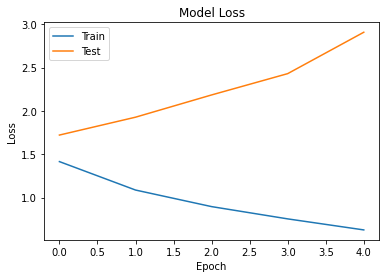

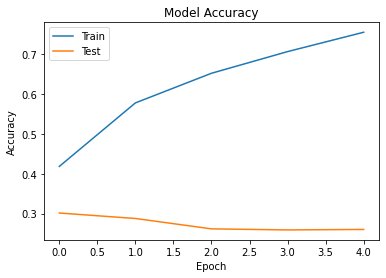

In [ ]:
plt_show_loss(training)
plt.show()

plt_show_acc(training)
plt.show()

### 함수를 정의하여 예측해보기

출력값에 따라 `사회, 정치, 경제, 국제, 문화, IT` 중 한 개의 예측값을 프린트한다

In [ ]:
def predict(new_article):
    new_article = okt.morphs(new_article, stem=True) # 토큰화
    new_article = [ word for word in new_article if not word in stopwords ] # 불용어 처리
    # 정수 인코딩
    encoded = tokenizer.texts_to_sequences([new_article])
    # 패딩
    padded = pad_sequences(encoded, maxlen=max_len)
    # 예측
    score = model.predict(padded)
    # for i in range(idx):
    #     print(max(score))
    cat = np.argmax(score)
    
    if cat == 0:
      print(f'사회')
    elif cat == 1:
      print(f'정치')
    elif cat == 2:
      print(f'경제')
    elif cat == 3:
      print(f'국제')
    elif cat == 4:
      print(f'문화')
    elif cat == 5:
      print(f'IT')
    # return score.round()

In [ ]:
predict("한전은 전력공급체계의 전면적인 혁신을 통해 탄소중립 시대를 선도하기 위한 목적으로 조직을 개편한다고 15일 밝혔다.")

정치


In [ ]:
predict("미국의 압박, 탈레반 확장..신장 두고 고민 깊어지는 中")

국제


# 과대적합 해결을 위한 2차 모델 생성
1. 훈련 데이터가 많아야한다.
2. 모델의 복잡도를 줄여아 한다

In [ ]:
model = Sequential([
        Embedding(vocab_size, 100),
        LSTM(32),
        Dense(6, activation='softmax')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1747400   
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
Total params: 1,764,622
Trainable params: 1,764,622
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['acc']
)

### 2차 모델 훈련

In [ ]:
training = model.fit(X_train_padded,
                     y_train,
                     epochs=30,
                     callbacks=[es, mc],
                     batch_size=32,
                     validation_split=0.2,
                     shuffle=True
)

Epoch 1/30
1994/1994 [==============================] - 69s 33ms/step - loss: 1.4063 - acc: 0.4244 - val_loss: 1.7821 - val_acc: 0.2819

Epoch 00001: val_acc did not improve from 0.30160
Epoch 2/30
1994/1994 [==============================] - 66s 33ms/step - loss: 1.0578 - acc: 0.5914 - val_loss: 1.9735 - val_acc: 0.2774

Epoch 00002: val_acc did not improve from 0.30160
Epoch 3/30
1994/1994 [==============================] - 64s 32ms/step - loss: 0.8685 - acc: 0.6672 - val_loss: 2.1302 - val_acc: 0.2822

Epoch 00003: val_acc did not improve from 0.30160
Epoch 4/30
1994/1994 [==============================] - 64s 32ms/step - loss: 0.7284 - acc: 0.7206 - val_loss: 2.4705 - val_acc: 0.2612

Epoch 00004: val_acc did not improve from 0.30160
Epoch 5/30
1994/1994 [==============================] - 65s 33ms/step - loss: 0.6073 - acc: 0.7676 - val_loss: 2.8100 - val_acc: 0.2756

Epoch 00005: val_acc did not improve from 0.30160
Epoch 00005: early stopping


### 시각화를 통해 확인

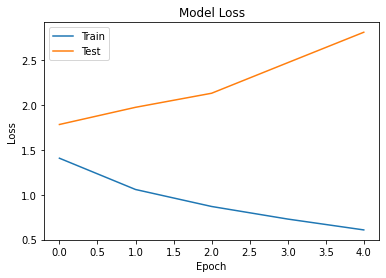

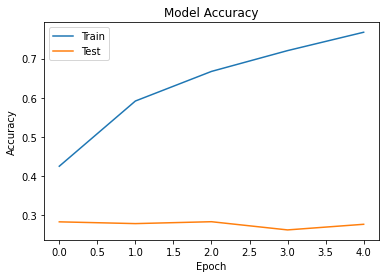

In [ ]:
plt_show_loss(training)
plt.show()

plt_show_acc(training)
plt.show()

# Feedback 정리

1. **주제와 관련된 데이터 수집**  
뉴스 크롤링 시에는 하나의 날짜의 많은 페이지를 크롤링하기보다는 다양한 날짜로 크롤링하는 것이 더 다양한 내용을 훈련시킬 수 있음

2. **희귀 단어 설정**  
희귀 단어 임계점이 너무 큼  
    ---> 데이터 자체도 적은데 희귀 단어가 너무 많다  
    ---> 데이터가 단순해져서 과대 적합이 되었을 가능성 큼  